# SVD Basis

## Preparation

In [1]:
from utility import *
from grid import *
from scipy import integrate
from scipy.interpolate import UnivariateSpline
import numpy.linalg as linalg

In [2]:
Para=param()
Grid=grid(Para)
TauGrid = Grid.TauGrid
MomGrid = Grid.MomGrid

 Parameters: 
Rs=1.0, kF=1.91915829268, EF=3.68316855235, Beta=10.8602143593, Mass2=0.0, Lambda=1.0

 Grid Information: 
TauSize=128, MomSize=64, AngleSize=64, RealFreqSize=1024, TauBasisNum=32
MaxRealFreq=110.495056571, MaxExtMom=5.75747487803

 Timer Information: 
Print=20, Save=20, ReWeight=30, Message=20, Collection=20
6.66666666667 0.10498687664


## Load Sigma Data

In [3]:
folder = "./Data"

filename = "sigma_pid[0-9]+.dat"

shape = (Para.Order+1, Para.MomGridSize, Para.TauGridSize)

Data, Norm, Step = LoadFile(folder, filename, shape)

Loading  ./Data/sigma_pid16.dat
Loading  ./Data/sigma_pid3.dat
Loading  ./Data/sigma_pid26.dat
Loading  ./Data/sigma_pid23.dat
Loading  ./Data/sigma_pid9.dat
Loading  ./Data/sigma_pid14.dat
Loading  ./Data/sigma_pid0.dat
Loading  ./Data/sigma_pid1.dat
Loading  ./Data/sigma_pid20.dat
Loading  ./Data/sigma_pid2.dat
Loading  ./Data/sigma_pid12.dat
Loading  ./Data/sigma_pid28.dat
Loading  ./Data/sigma_pid19.dat
Loading  ./Data/sigma_pid25.dat
Loading  ./Data/sigma_pid15.dat
Loading  ./Data/sigma_pid4.dat
Loading  ./Data/sigma_pid29.dat
Loading  ./Data/sigma_pid22.dat
Loading  ./Data/sigma_pid27.dat
Loading  ./Data/sigma_pid30.dat
Loading  ./Data/sigma_pid13.dat
Loading  ./Data/sigma_pid11.dat
Loading  ./Data/sigma_pid6.dat
Loading  ./Data/sigma_pid18.dat
Loading  ./Data/sigma_pid5.dat
Loading  ./Data/sigma_pid7.dat
Loading  ./Data/sigma_pid24.dat
Loading  ./Data/sigma_pid21.dat
Loading  ./Data/sigma_pid10.dat
Loading  ./Data/sigma_pid8.dat
Loading  ./Data/sigma_pid17.dat


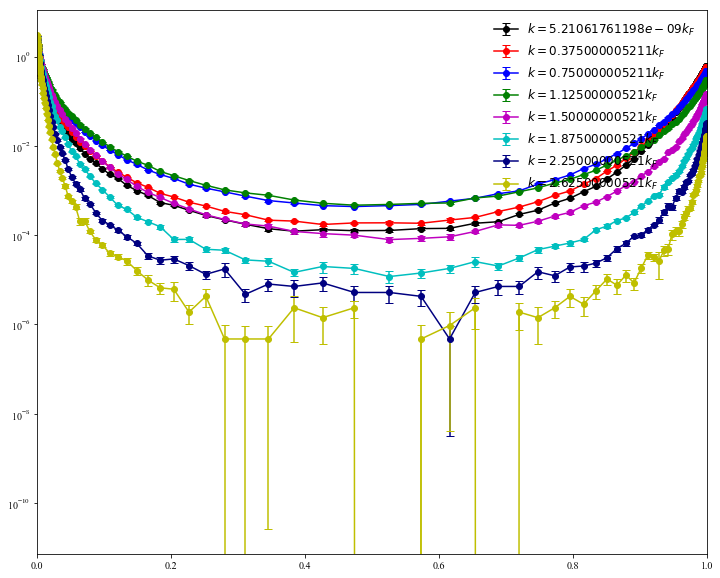

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))
N = 8
o = 2
for i in range(N):
    q = i*Para.MomGridSize/N
    Avg, Err = Estimate(Data, Norm)
    ax.errorbar(TauGrid/Para.Beta, -Avg[o, q, :], yerr=Err[o, q, :], fmt='o-',
                capthick=1, capsize=4, color=ColorList[i], label="$k={0}k_F$".format(MomGrid[q]/Para.kF))
    
ax.set_yscale("log")
#ax.set_xlim([4.5, 6.5])
ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.show()

## Basis Construction

In [5]:
def FermiKernel(w, t, beta):
    x = beta*w/2
    y = 2*t/beta-1
    if x > 100:
        return np.exp(-x*(y+1.))
    if x < -100:
        return np.exp(x*(1.0-y))
    return np.exp(-x*y)/(2*np.cosh(x))

[1.04834812e-14 5.50886543e-15 1.97974355e-15 1.75285346e-15
 1.28967693e-15]


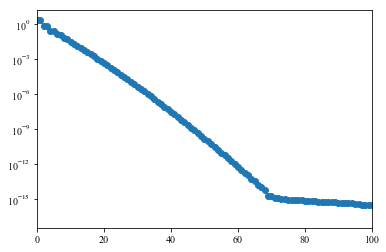

In [6]:
Nw = 1024
Wmax=100
w = np.linspace(-Wmax, Wmax, Nw)
Nt = len(TauGrid)
kMatrix = np.zeros([Nw, Nt])

for i in range(len(w)):
    kMatrix[i, :] = FermiKernel(w[i], TauGrid, Para.Beta)*2.0*Wmax/Nw/2.0/np.pi

u, s, v = linalg.svd(kMatrix)
v_inv = linalg.inv(v)
u_inv=linalg.inv(u)
N=128
x=range(N)
y=s[:N]
print s[67:72]
plt.plot(x, y, 'o-')
plt.yscale('log')
plt.xlim([0.0, 100])
plt.show()

## Basis Fit

-2.62377583959952 0.019980296299121424
0.07087949102665192


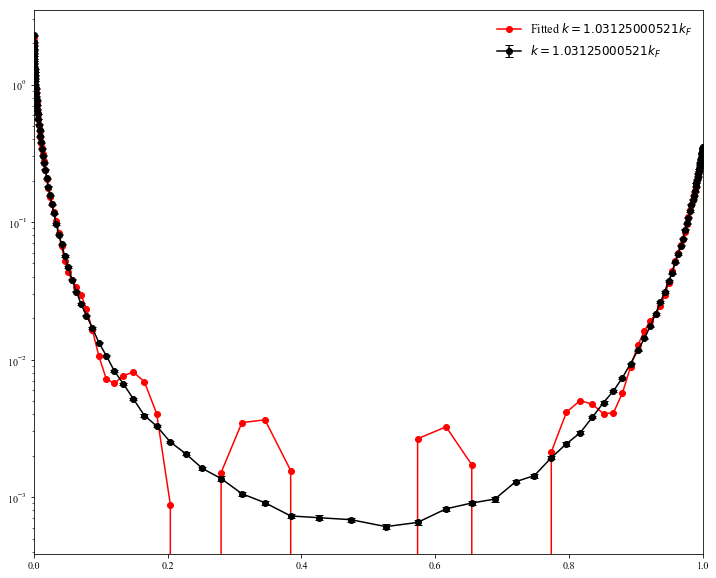

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
N = 8
o = 2
q=22
Nlim=32

SigmaT, Err = Estimate([d[o, q, :] for d in Data], Norm)

print SigmaT[-1]+SigmaT[0], Err[-1]+Err[0]

Elem=np.dot(SigmaT, v.T[:,:Nlim])
Fitted=np.dot(Elem, v[:Nlim,:])
    
ax.errorbar(TauGrid/Para.Beta, -SigmaT, yerr=Err, fmt='o-',
            capthick=1, capsize=4, color=ColorList[0], label="$k={0}k_F$".format(MomGrid[q]/Para.kF))
    
ax.plot(TauGrid/Para.Beta, -Fitted, 'o-'
            , color=ColorList[1], label="Fitted $k={0}k_F$".format(MomGrid[q]/Para.kF))

print np.amax(abs(SigmaT-Fitted))

ax.set_yscale("log")
ax.set_xlim([0.0, 1.0])
#ax.set_ylim([0.0, 0.1])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.show()

## Signular value versus Coefficient

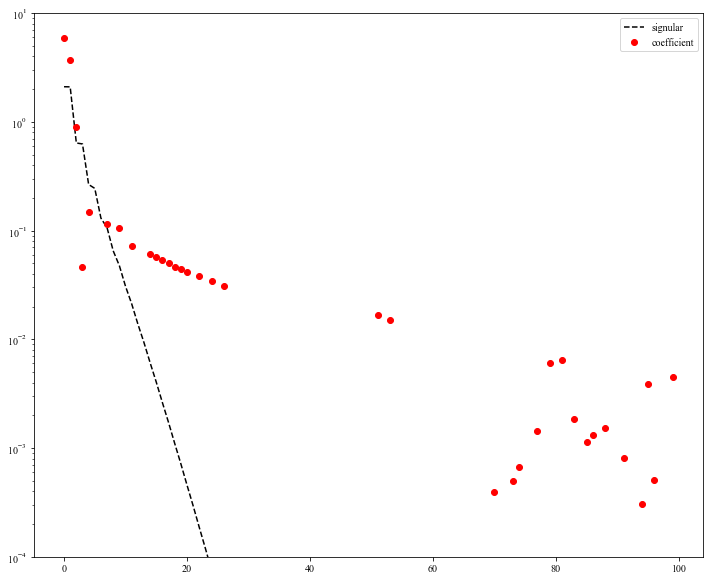

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))

Nlim=100

SigmaT, Err = Estimate([d[o, q, :] for d in Data], Norm)

Elem=np.dot(SigmaT, v.T[:,:Nlim])
    
x=range(Nlim)
y=s[:Nlim]
plt.plot(x, y, 'k--', label="signular")
plt.plot(x, Elem, 'ro', label="coefficient")
plt.legend()
plt.yscale('log')
plt.ylim([1.e-4, 10])
plt.show()

## Specutral function

-2.5988186772981514


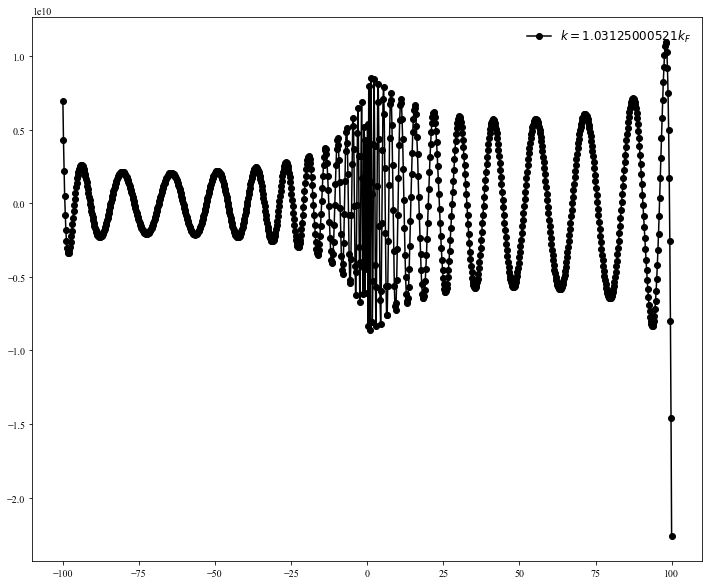

In [10]:
ss=np.zeros((Nt, Nw))
Nsvd=64
for i in range(Nsvd):
    ss[i, i]=1.0/s[i]

InvKernel=np.dot(np.dot(v.T, ss), u.T)
spectral=np.dot(SigmaT, InvKernel)

print np.sum(spectral)*2.0*Wmax/Nw/2.0/np.pi

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(w, spectral, 'ko-', label="$k={0}k_F$".format(MomGrid[q]/Para.kF))
    
#ax.set_yscale("log")
#ax.set_xlim([0.0, 0.2])
#ax.set_ylim([0.0, 0.1])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.show()

## Matsubara Frequency Basis

4.0474195101649075e-14


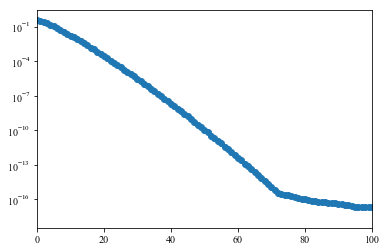

In [11]:
def FermiKernelMatFreq(w, wn, beta):
    return 1.0/(1j*wn+w)/2.0/np.pi

WnMax=1024
Wn = (np.array(range(-WnMax, WnMax))*2.0+1.0)*np.pi/Para.Beta
Nwn=len(Wn)
MatFreqMatrix = np.zeros([Nw, len(Wn)], dtype=complex)

for i in range(len(w)):
    MatFreqMatrix[i, :] = FermiKernelMatFreq(w[i], Wn, Para.Beta)*2.0*Wmax/Nw

uw, sw, vw = linalg.svd(MatFreqMatrix)

x=range(Nw)
y=sw[:Nw]
print sw[Nsvd]
#print Nw, len(s)
#print y.shape, len(x)
plt.plot(x, y, 'o-')
plt.yscale('log')
plt.xlim([0.0, 100])
plt.show()

## Matsubara Frequency Sigma

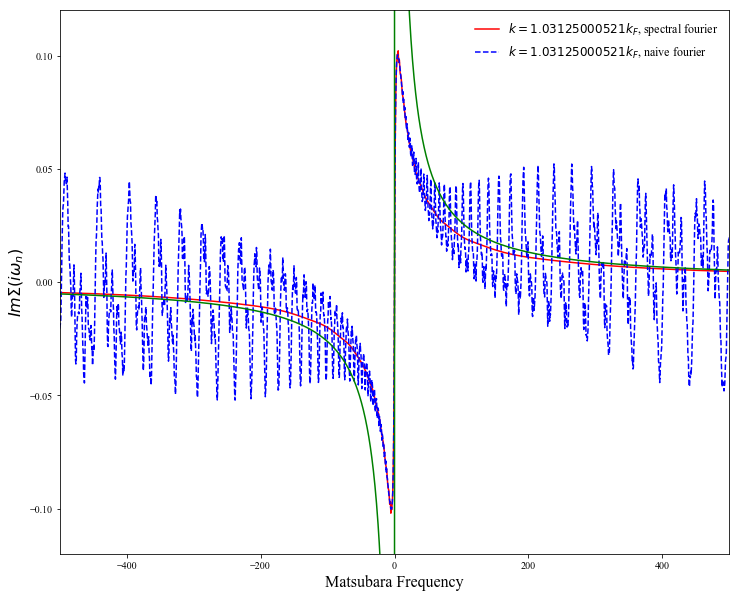

In [12]:
ssw=np.zeros((Nw, Nwn))
#ssw=sw
for i in range(128):
    ssw[i, i]=sw[i]

SigmaW=np.dot(np.dot(np.dot(spectral, uw), ssw), vw)

## Benchmark

SigmaW_ref=np.zeros_like(SigmaW)

for i, freq in enumerate(Wn):
    dw = SigmaT*np.exp(-1j*TauGrid*freq)
    SigmaW_ref[i] = integrate.trapz(dw, TauGrid)

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(Wn, SigmaW.imag, 'r-',  label="$k={0}k_F$, spectral fourier".format(MomGrid[q]/Para.kF))  
ax.plot(Wn, SigmaW_ref.imag, 'b--', label="$k={0}k_F$, naive fourier".format(MomGrid[q]/Para.kF))  
#ax.plot(Wn, 1.85606/Wn, 'k-')
ax.plot(Wn, 2.63/Wn, 'g-')
#ax.set_yscale("log")
ax.set_xlim([-500, 500])
#ax.set_xlim([0, 30])
ax.set_xlabel("Matsubara Frequency", size=16)
ax.set_ylabel("$Im\Sigma(i\omega_n)$", size=16)
ax.set_ylim([-0.12, 0.12])
#ax.set_xlim([50, 200])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])

plt.legend(loc=1, frameon=False, fontsize=size)
#plt.savefig("sigma.pdf")
plt.show()

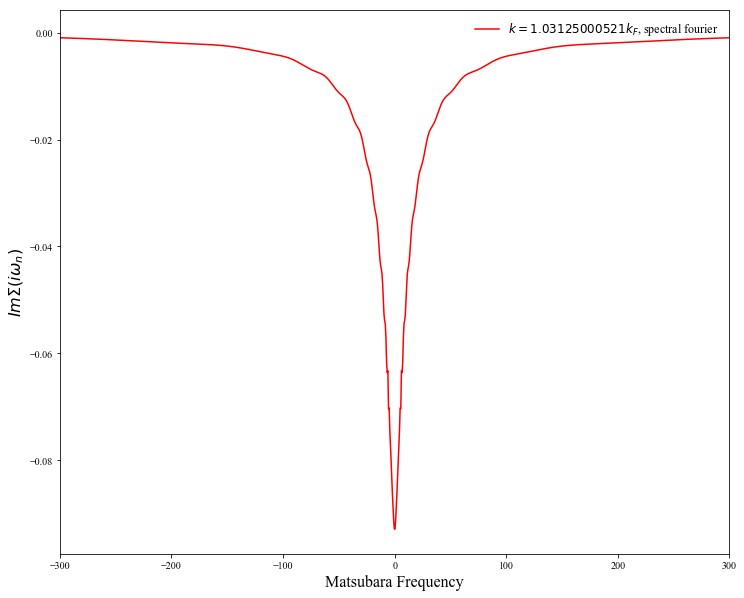

In [13]:
ssw=np.zeros((Nw, Nwn))
#ssw=sw
for i in range(Nsvd):
    ssw[i, i]=sw[i]

SigmaW=np.dot(np.dot(np.dot(spectral, uw), ssw), vw)

## Benchmark

SigmaW_ref=np.zeros_like(SigmaW)

for i, freq in enumerate(Wn):
    dw = SigmaT*np.exp(-1j*TauGrid*freq)
    SigmaW_ref[i] = integrate.trapz(dw, TauGrid)

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(Wn, SigmaW.real, 'r-',  label="$k={0}k_F$, spectral fourier".format(MomGrid[q]/Para.kF))  
#ax.plot(Wn, SigmaW_ref.real, 'b--', label="$k={0}k_F$, naive fourier".format(MomGrid[q]/Para.kF))  
#ax.set_yscale("log")
ax.set_xlim([-300, 300])
#ax.set_xlim([0, 30])
ax.set_xlabel("Matsubara Frequency", size=16)
ax.set_ylabel("$Im\Sigma(i\omega_n)$", size=16)
#ax.set_ylim([-0.10, -0.04])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])

plt.legend(loc=1, frameon=False, fontsize=size)
#plt.savefig("sigma.pdf")
plt.show()